In [6]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import sys
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import scanpy as sc
import math
from scipy import sparse
import scvelo as scv

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
%%memit
adata_file = '/home/ngr4/project/scnd/data/processed/mouse_200614.h5ad'
adata = sc.read(adata_file)

peak memory: 10793.99 MiB, increment: 10594.63 MiB


In [8]:
tdata = adata[((adata.obs['ctype']=='Oligodendrocyte progenitor cell') | (adata.obs['ctype']=='Oligodendrocyte')), :]

In [13]:
sc.external.tl.harmony_timeseries(tdata, tp="timepoint", n_components=500)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
Harmony augmented affinity matrix


Running PCA with 500 components


computing neighbors


Nearest neighbor computation...


    finished (0:01:53)


Constucting affinities between 5wk and 12wk...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 12wk and 18wk...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 18wk and 24wk...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 24wk and 30wk...
t+1 neighbors of t...
t neighbors of t+1...


100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


BarnesHut Approximation  took  31.15  seconds
Repulsion forces  took  41.12  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  2.72  seconds
AdjustSpeedAndApplyForces step  took  1.09  seconds


In [14]:
tdata

AnnData object with n_obs × n_vars = 10382 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'louvain', 'neighbors', 'pca', 'umap', 'harmony_timepoint_var', 'harmony_timepoint_connections'
    obsm: 'X_pca', 'X_phate', 'X_umap', 'X_harmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'harmony_aff', 'harmony_aff_aug'

In [16]:
tdata.obsp['harmony_aff_aug'][0:3, 0:3].todense()

matrix([[2., 0., 0.],
        [0., 2., 0.],
        [0., 0., 2.]])

In [21]:
# randomly pick OPC from 5wk 
start_cellid = tdata.obs.loc[(tdata.obs['timepoint']=='5wk') & (tdata.obs['ctype']=='Oligodendrocyte progenitor cell'), :].sample(1).index[0]

In [26]:
sc.external.tl.palantir(tdata,
    use_adjacency_matrix=True,
    distances_key='harmony_aff_aug')

Palantir Diffusion Maps in progress ...


In [27]:
tdata

AnnData object with n_obs × n_vars = 10382 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'louvain', 'neighbors', 'pca', 'umap', 'harmony_timepoint_var', 'harmony_timepoint_connections', 'palantir_EigenValues'
    obsm: 'X_pca', 'X_phate', 'X_umap', 'X_harmony', 'X_palantir_diff_comp', 'X_palantir_multiscale'
    varm: 'PCs'
    layers: 'palantir_imp'
    obsp: 'connectivities', 'distances', 'harmony_aff', 'harmony_aff_aug', 'palantir_diff_op'

In [28]:
sc.tl.tsne(tdata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=150)

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:51)


<AxesSubplot:>

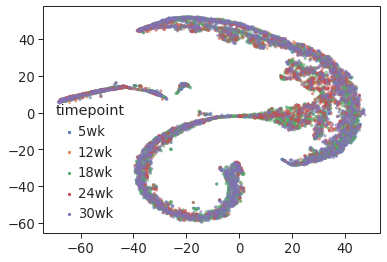

In [55]:
sns.scatterplot(x=tdata.obsm['X_tsne'][:, 0],
                y=tdata.obsm['X_tsne'][:, 1],
                hue=tdata.obs['timepoint'],
                linewidth=0, 
                s=10, alpha=0.6)

In [47]:
x = sc.external.tl.palantir_results(tdata,
                                early_cell=start_cellid)

Palantir computing waypoints..


Sampling and flocking waypoints...
Time for determining waypoints: 0.021886670589447023 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.16838104327519735 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [49]:
dir(x)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_branch_probs',
 '_entropy',
 '_pseudotime',
 '_waypoints',
 'branch_probs',
 'entropy',
 'load',
 'pseudotime',
 'save',
 'waypoints']

In [46]:
tdata.uns['harmony_timepoint_var']

'timepoint'

In [51]:
tdata.obs['pr_pseudotime'] = x.pseudotime

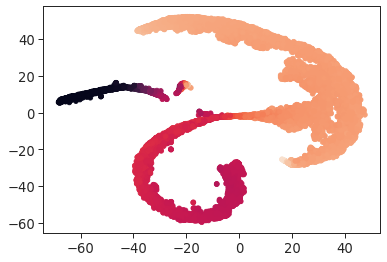

In [53]:
plt.scatter(tdata.obsm['X_tsne'][:, 0], 
            tdata.obsm['X_tsne'][:, 1],
            c=tdata.obs['pr_pseudotime'].to_numpy())